In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

### Load data

In [2]:
destination_path = "C:/Users/gianl/Desktop/Gi/Supsi/MartaLauraGiada/Laura/Tweets/"

In [3]:
tweets_with_urls = pd.read_parquet(destination_path+'tweets_w_urls_decompressed (1.0).parquet',
                               engine='fastparquet')

In [ ]:
tweets_with_urls.info()

In [102]:
value = []
for i in tqdm(tweets_with_urls["urls"]):
    url_exp = i.split(" ")
    lst_inside = []
    for exp in range(len(url_exp)):
        if url_exp[exp] == "'expanded_url':":
            lst_inside.append(url_exp[exp+1][1:-2])
    value.append(lst_inside)


In [103]:
def extract_domain_list(url_list):
    domain_list = []
    cont = 0
    for url in url_list:
        cont = cont + 1
        inside = []
        for i in url:
            try:
                x = i.split("/")[2]
            except:
                x = "napolimagazine.com"
            if "www." in x:
                x = x[4:]
            inside.append(x)
        domain_list.append(inside)
    return domain_list

In [104]:
x = extract_domain_list(value)

In [108]:
print(len(x))
print(len(tweets_with_urls))
tweets_with_urls["domain"] = x

1030912
1030912


In [110]:
tweets_with_urls.to_parquet(destination_path+"tweets_with_domains (2.0).parquet", index=False)

# Domain with the same name written in a different way

In [113]:
def normalize_domains(domain_list):
    for idx in range(len(domain_list)):
        domain=domain_list[idx]
        if domain in domain_normalize_df['initial_domain'].values:
            domain_list[idx] = domain_list[idx].replace(domain, domain_normalize_df[domain_normalize_df['initial_domain']==domain]['final_domain'].values[0])
    return domain_list

In [5]:
path_cred = "C:/Users/gianl/Desktop/Gi/Supsi/MartaLauraGiada/Laura/Files/"

In [66]:
#read csv with "initial_domain" and "final_domain" to substitute name of same domain expressed in different ways
domain_normalize_df = pd.read_csv(path_cred+'Domain_to_normalize.csv', sep=',')
domain_normalize_df.drop_duplicates(inplace=True)
domain_normalize_df

In [130]:
#create df with one row for every domain
domain_df = tweets_with_urls['domain'].apply(pd.Series).reset_index().melt(id_vars='index').dropna()[['index', 'value']].set_index('index') #create df of url with one url per row

# Credibility

In [2]:
path_cred = "C:/Users/gianl/Desktop/Gi/Supsi/MartaLauraGiada/"

In [3]:
#change path and filename 
wider_cred_sources_df = pd.read_csv(path_cred+'final_urls.csv')
high_cred_df = wider_cred_sources_df[wider_cred_sources_df['credibility'] == 'high']
high_cred_df.drop_duplicates(inplace=True)
low_cred_df = wider_cred_sources_df[wider_cred_sources_df['credibility'] == 'low']
low_cred_df.drop_duplicates(inplace=True)

<ipython-input-3-ebafdefb9a17>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_cred_df.drop_duplicates(inplace=True)
<ipython-input-3-ebafdefb9a17>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_cred_df.drop_duplicates(inplace=True)


In [4]:
high_cred_df

,url,credibility
40,noidiminerva.it,high
43,superquark.rai.it,high
45,leganerd.com,high
49,medicisenzafrontiere.it,high
50,avvenire.it,high
...,...,...
1274,unep.org,high
1275,ornl.gov,high
1276,vaxopedia.or,high
1277,verywellfamily.com,high


In [5]:
low_cred_df

,url,credibility
0,il-quotidiano.info,low
1,terrarealtime.blogspot.com,low
2,it.sputniknews.com,low
3,laverita.info,low
4,liberoquotidiano.it,low
...,...,...
1421,nonsiamosoli.net,low
1422,pianetablunews.it,low
1423,ricercaIndipendente.net,low
1424,saltoquantico.org,low


In [6]:
low_cred_df = low_cred_df.rename(columns={"url": "LOW"})
high_cred_df = high_cred_df.rename(columns={"url": "HIGH"})

In [7]:
social_media_df = pd.read_excel(path_cred+'social_media_sources.xlsx')
social_media_df.drop_duplicates(inplace=True)

In [8]:
social_media_df

,SOCIAL-MEDIA
0,twitter.com
1,instagram.com
2,youtu.be
3,youtube.com
4,facebook.com


In [90]:
print(f'Possible low credibility sources = {len(low_cred_df)}')
print(f'Possible high credibility sources = {len(high_cred_df)}')
print(f'Possible social media sources = {len(social_media_df)}')

Possible low credibility sources = 1198
Possible high credibility sources = 195
Possible social media sources = 5


In [9]:
tweets_with_urls = pd.read_parquet("C:/Users/gianl/Desktop/Gi/Supsi/MartaLauraGiada/Laura/Tweets/tweets_with_domains (2.0).parquet")
tweets_with_urls

,id,id_str,created_at,user_id,user_screen_name,user_verified,user_created_at,text,source,coordinates,...,hashtags,symbols,user_mentions,urls,polls,media,user_tweets_count,user_friends_count,user_followers_count,domain
0,1221737654909382662,1221737654909382662,Mon Jan 27 10:12:10 +0000 2020,589884969,LecceSette,False,Fri May 25 08:09:46 +0000 2012,"Minaccia morbillo nel Salento, Asl: ""Vaccinars...","<a href=""https://ifttt.com"" rel=""nofollow"">IFT...",None,...,[],[],[],"[{'url': 'https://t.co/CY0qiQFk6s', 'expanded_...",[],[],NaN,NaN,NaN,[leccesette.it]
1,1221738978585563136,1221738978585563136,Mon Jan 27 10:17:25 +0000 2020,166708308,Asgard_Hydra,False,Wed Jul 14 20:31:11 +0000 2010,Ricercatori a lavoro per produrre vaccino cont...,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",None,...,[],[],[],"[{'url': 'https://t.co/2bcyuvpnhj', 'expanded_...",[],[],NaN,NaN,NaN,[tech.everyeye.it]
2,1221728158371786752,1221728158371786752,Mon Jan 27 09:34:26 +0000 2020,836069429209227264,italyinkz,True,Mon Feb 27 04:24:20 +0000 2017,"#27gennaio \n""Coltivare la Memoria è ancora og...","<a href=""https://mobile.twitter.com"" rel=""nofo...",None,...,"[{'text': '27gennaio', 'indices': [0, 10]}, {'...",[],[],"[{'url': 'https://t.co/mlmAR0xufR', 'expanded_...",[],[],NaN,NaN,NaN,[twitter.com]
3,1221735550585053186,1221735550585053186,Mon Jan 27 10:03:48 +0000 2020,1019640307065982979,CeSPI_Roma,False,Wed Jul 18 17:49:28 +0000 2018,Per chi crede nella democrazia nel rispetto de...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",None,...,"[{'text': 'antisemitismo', 'indices': [118, 13...",[],"[{'screen_name': 'pierofassino', 'name': 'Pier...","[{'url': 'https://t.co/bPHttOpFcg', 'expanded_...",[],"[{'id': 1221735545799352322, 'id_str': '122173...",NaN,NaN,NaN,[cespi.it]
4,1221734125725540352,1221734125725540352,Mon Jan 27 09:58:08 +0000 2020,59720254,_teo777,False,Fri Jul 24 07:35:06 +0000 2009,"Piove, novacse ladro!\n\n""Avete fatto vincere""...","<a href=""https://mobile.twitter.com"" rel=""nofo...",None,...,[],[],[],"[{'url': 'https://t.co/RjXrEYu3yv', 'expanded_...",[],[],NaN,NaN,NaN,[twitter.com]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1030907,1394609850089345025,1394609850089345025,Tue May 18 11:04:33 +0000 2021,71210454,tuttoggi,False,Thu Sep 03 09:01:38 +0000 2009,Anche i carabinieri del Nas potrebbero interes...,"<a href=""https://www.postpickr.com"" rel=""nofol...",None,...,"[{'text': 'politica', 'indices': [140, 149]}, ...",[],[],"[{'url': 'https://t.co/db99chESX6', 'expanded_...",[],[],93104.0,228.0,3744.0,[tuttoggi.info]
1030908,1394609946881298432,1394609946881298432,Tue May 18 11:04:56 +0000 2021,2926782875,Mustapha1508,False,Wed Dec 17 10:59:26 +0000 2014,"Vaccino, dopo il caso della 23enne un altro er...","<a href=""http://twitter.com/download/iphone"" r...",None,...,[],[],"[{'screen_name': 'Corriere', 'name': 'Corriere...","[{'url': 'https://t.co/00QUDugAgD', 'expanded_...",[],[],50672.0,5003.0,3923.0,[csera.it]
1030909,1394610031262306304,1394610031262306304,Tue May 18 11:05:16 +0000 2021,4309630395,Ileana0406,False,Sat Nov 28 18:18:40 +0000 2015,"Vaccini, nuovo errore di somministrazione in T...","<a href=""http://twitter.com/download/iphone"" r...",None,...,"[{'text': 'covid', 'indices': [97, 103]}]",[],"[{'screen_name': 'MediasetTgcom24', 'name': 'T...","[{'url': 'https://t.co/JUsPLDG9vB', 'expanded_...",[],[],21105.0,1130.0,833.0,[tgcom24.mediaset.it]
1030910,1394610015823147011,1394610015823147011,Tue May 18 11:05:13 +0000 2021,497188910,Rosskitty77,False,Sun Feb 19 18:26:36 +0000 2012,"""...«Ha lividi e piastrine basse». E ha richie...","<a href=""https://mobile.twitter.com"" rel=""nofo...",None,...,[],[],[],"[{'url': 'https://t.co/5UT12c2sur', 'expanded_...",[],[],79297.0,772.0,893.0,[twitter.com]


In [92]:
lst = []
lst_domains = []
for row in tqdm(tweets_with_urls.itertuples()):
    lst_inside = []
    for i in row.domain:
        lst_inside.append(i.lower())
    lst.append(len(row.domain))
    lst_domains.append(lst_inside)
tweets_with_urls["number_of_urls"] = lst
tweets_with_urls["domain"] = lst_domains

In [93]:
low = list(low_cred_df["LOW"])
high = list(high_cred_df["HIGH"])
social = list(social_media_df["SOCIAL-MEDIA"])
list_of_low = []
list_of_high = []
list_of_unkw = []
list_of_social = []
for row in tqdm(tweets_with_urls.itertuples()):
    value_low = 0
    value_high = 0
    value_unk= 0
    value_social = 0
    for domain in row.domain:
        if domain in low:
            value_low = value_low + 1 
        elif domain in high:
            value_high = value_high + 1
        elif domain in social:
            value_social = value_social + 1
        else:
            value_unk = value_unk+ 1
    list_of_low.append(value_low)
    list_of_high.append(value_high)
    list_of_unkw.append(value_unk)
    list_of_social.append(value_social)

In [94]:
tweets_with_urls['LOW'] = list_of_low
tweets_with_urls['HIGH'] = list_of_high
tweets_with_urls['UNKW'] = list_of_unkw
tweets_with_urls['SOCIAL'] = list_of_social

In [10]:
destination_path

NameError: name 'destination_path' is not defined

In [95]:
tweets_with_urls.to_parquet(destination_path+"tweets_with_urls_and_domain_and_score (3.0).parquet", index=False)

In [96]:
tweets_with_urls[tweets_with_urls["number_of_urls"]==2]

,id,id_str,created_at,user_id,user_screen_name,user_verified,user_created_at,text,source,coordinates,...,media,user_tweets_count,user_friends_count,user_followers_count,domain,number_of_urls,LOW,HIGH,UNKW,SOCIAL
41,1221595080244498432,1221595080244498432,Mon Jan 27 00:45:37 +0000 2020,765249168,SuoreDiMenare,False,Sat Aug 18 07:17:38 +0000 2012,@Corradobl @Dario_Donato @stanzaselvaggia Ness...,"<a href=""http://twitter.com/download/iphone"" r...",None,...,[],NaN,NaN,NaN,"[twitter.com, twitter.com]",2,0,0,0,2
101,1222255264348418048,1222255264348418048,Tue Jan 28 20:28:58 +0000 2020,1116090803900887041,bluebird19473,False,Wed Apr 10 21:29:18 +0000 2019,@EuroMasochismo Poi qualcuno mi spiega cosa in...,"<a href=""http://twitter.com/download/android"" ...",None,...,[],NaN,NaN,NaN,"[youtu.be, youtu.be]",2,0,0,0,2
422,1213108298980958210,1213108298980958210,Fri Jan 03 14:42:11 +0000 2020,523153746,TG24info,False,Tue Mar 13 11:32:04 +0000 2012,#Regione - Prosegue la campagna regionale vacc...,"<a href=""http://www.tg24.info"" rel=""nofollow"">...",None,...,"[{'id': 1213108296657391616, 'id_str': '121310...",NaN,NaN,NaN,"[tg24.info, tg24.info]",2,0,0,2,0
488,1212986900765646848,1212986900765646848,Fri Jan 03 06:39:48 +0000 2020,1908575102,rosati22,False,Thu Sep 26 17:09:26 +0000 2013,"Meningite, il mostro che uccide in silenzio: a...","<a href=""http://twitter.com"" rel=""nofollow"">Tw...",None,...,[],NaN,NaN,NaN,"[genova24.it, genova24.it]",2,0,0,2,0
725,1223189700216872960,1223189700216872960,Fri Jan 31 10:22:04 +0000 2020,1091380531,ansia_tw,False,Tue Jan 15 08:12:27 +0000 2013,@GianricoCarof Personalmente preferisco chi us...,"<a href=""http://twitter.com/#!/download/ipad"" ...",None,...,[],NaN,NaN,NaN,"[twitter.com, twitter.com]",2,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1030832,1394607555050098691,1394607555050098691,Tue May 18 10:55:26 +0000 2021,3300222131,paolovarsi1,False,Wed May 27 07:50:03 +0000 2015,@doluccia16 https://t.co/eoDMuNwKzw\n- Il vacc...,"<a href=""http://twitter.com/download/android"" ...",None,...,[],114220.0,234.0,381.0,"[maurizioblondet.it, laforzadellaverita.com]",2,2,0,0,0
1030836,1394607447499853827,1394607447499853827,Tue May 18 10:55:00 +0000 2021,3300222131,paolovarsi1,False,Wed May 27 07:50:03 +0000 2015,@doluccia16 https://t.co/eoDMuNwKzw\n- Il vacc...,"<a href=""http://twitter.com/download/android"" ...",None,...,[],114220.0,234.0,381.0,"[maurizioblondet.it, laforzadellaverita.com]",2,2,0,0,0
1030855,1394607773883772933,1394607773883772933,Tue May 18 10:56:18 +0000 2021,3300222131,paolovarsi1,False,Wed May 27 07:50:03 +0000 2015,@danielamartani https://t.co/eoDMuNwKzw\n- Il ...,"<a href=""http://twitter.com/download/android"" ...",None,...,[],114220.0,234.0,381.0,"[maurizioblondet.it, laforzadellaverita.com]",2,2,0,0,0
1030856,1394608150360248322,1394608150360248322,Tue May 18 10:57:48 +0000 2021,3300222131,paolovarsi1,False,Wed May 27 07:50:03 +0000 2015,@msgelmini https://t.co/eoDMuNwKzw\n- Il vacci...,"<a href=""http://twitter.com/download/android"" ...",None,...,[],114220.0,234.0,381.0,"[maurizioblondet.it, laforzadellaverita.com]",2,2,0,0,0


In [97]:
sum_of_urls_df = tweets_with_urls.groupby(['user_screen_name'])[['number_of_urls','HIGH','LOW','UNKW','SOCIAL']].sum()
sum_of_urls_df=sum_of_urls_df.sort_values(by=['number_of_urls'], ascending=False)
sum_of_urls_df.head(10)

,number_of_urls,HIGH,LOW,UNKW,SOCIAL
user_screen_name,,,,,
infoitinterno,17471,17269,0,202,0
infoitsalute,16086,15870,0,216,0
infoiteconomia,6120,6029,1,90,0
zazoomblog,6033,0,6021,12,0
IacobellisT,3616,20,772,963,1861
Notiziedi_it,3529,3529,0,0,0
TommyBrain,3308,25,730,877,1676
Novanews242,3307,0,3284,8,15
infoitesteri,3095,3051,0,44,0


In [147]:
threshold_high_low = 50
sum_of_urls_df_10 = sum_of_urls_df[sum_of_urls_df['number_of_urls']>=threshold_high_low]

In [148]:
sum_of_urls_df_10['conspiracy_score'] = np.around(((sum_of_urls_df_10['LOW'])/(sum_of_urls_df_10['HIGH']+sum_of_urls_df_10['LOW']+sum_of_urls_df_10['UNKW'])),2)
sum_of_urls_df_10=sum_of_urls_df_10.sort_values(by=['conspiracy_score'], ascending=False)
sum_of_urls_df_10.head(10)

<ipython-input-148-6aeae9c184a2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sum_of_urls_df_10['conspiracy_score'] = np.around(((sum_of_urls_df_10['LOW'])/(sum_of_urls_df_10['HIGH']+sum_of_urls_df_10['LOW']+sum_of_urls_df_10['UNKW'])),2)


,number_of_urls,HIGH,LOW,UNKW,SOCIAL,conspiracy_score
user_screen_name,,,,,,
aVg,54,0,54,0,0,1.0
FarodiRoma,392,0,392,0,0,1.0
BlogNews_it,752,0,752,0,0,1.0
apetrazzuolo,335,0,335,0,0,1.0
zazoomblog,6033,0,6021,12,0,1.0
salernonotizie,890,0,889,1,0,1.0
Ziare_com,606,0,605,1,0,1.0
SmorfiaDigitale,606,0,603,3,0,1.0
Noovyis,942,0,942,0,0,1.0


In [149]:
# sum_of_urls_df_10.to_csv(destination_path+"result_cred_score_thresh_10.csv", index=False)

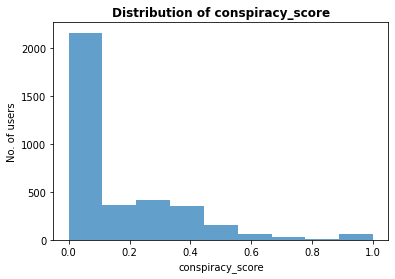

In [150]:
# distribution of scores
plt.hist(list(sum_of_urls_df_10['conspiracy_score']), bins=9, alpha=0.7)
plt.xlabel('conspiracy_score')
plt.ylabel('No. of users')
plt.title('Distribution of conspiracy_score', weight='bold')
#plt.savefig('plots/dist', bbox_inches='tight')
plt.show()

In [151]:
sum_of_urls_df_10[sum_of_urls_df_10["conspiracy_score"]>=0.7]

,number_of_urls,HIGH,LOW,UNKW,SOCIAL,conspiracy_score
user_screen_name,,,,,,
aVg,54,0,54,0,0,1.00
FarodiRoma,392,0,392,0,0,1.00
BlogNews_it,752,0,752,0,0,1.00
apetrazzuolo,335,0,335,0,0,1.00
zazoomblog,6033,0,6021,12,0,1.00
...,...,...,...,...,...,...
cadfael2,134,8,68,19,39,0.72
GiovanniCalcara,159,11,65,15,68,0.71
gerturco,91,9,37,6,39,0.71


In [105]:
threshold_high_low = 5
sum_of_urls_df_5 = sum_of_urls_df[sum_of_urls_df['HIGH']+sum_of_urls_df['LOW']>=threshold_high_low]

In [106]:
#sum_of_urls_df['conspiracy_score'] = np.around((sum_of_urls_df['LOW'] /(sum_of_urls_df['number_of_urls']-sum_of_urls_df['UNKW']-sum_of_urls_df['SOCIAL'])),2)
sum_of_urls_df_5['conspiracy_score'] = np.around(((sum_of_urls_df_5['LOW'])/(sum_of_urls_df_5['LOW']+sum_of_urls_df_5['HIGH'])),2)
#sum_of_urls_df['conspiracy_score'] = np.around(((sum_of_urls_df['LOW'])/(sum_of_urls_df['number_of_urls'])))
sum_of_urls_df_5=sum_of_urls_df_5.sort_values(by=['conspiracy_score'], ascending=False)
sum_of_urls_df_5.head(10)
##

<ipython-input-106-becb034d4d9e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sum_of_urls_df_5['conspiracy_score'] = np.around(((sum_of_urls_df_5['LOW'])/(sum_of_urls_df_5['LOW']+sum_of_urls_df_5['HIGH'])),2)


,number_of_urls,HIGH,LOW,UNKW,SOCIAL,conspiracy_score
user_screen_name,,,,,,
eston07390779,16,0,11,5,0,1.0
Pensant50024857,78,0,6,12,60,1.0
GoodTrueNews,16,0,16,0,0,1.0
serravalleweb1,12,0,5,7,0,1.0
moreno_0987,52,0,16,27,9,1.0
ValleMorte,22,0,22,0,0,1.0
ClaraLpz3,16,0,5,3,8,1.0
IlPrimatoN,174,0,174,0,0,1.0
Castelvico,7,0,6,1,0,1.0


In [107]:
sum_of_urls_df_5.to_csv(destination_path+"result_cred_score_thresh_5.csv", index=False)

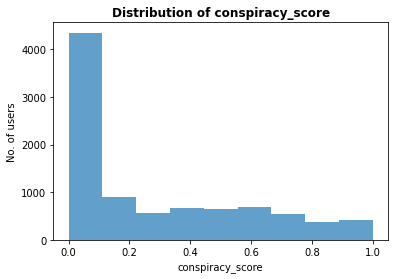

In [108]:
# distribution of scores
plt.hist(list(sum_of_urls_df_5['conspiracy_score']), bins=9, alpha=0.7)
plt.xlabel('conspiracy_score')
plt.ylabel('No. of users')
plt.title('Distribution of conspiracy_score', weight='bold')
#plt.savefig('plots/dist', bbox_inches='tight')
plt.show()

In [236]:
sum_of_urls_df_5.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8628 entries, GanTekAss to kyyy_mi
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   number_of_urls    8628 non-null   int64  
 1   HIGH              8628 non-null   int64  
 2   LOW               8628 non-null   int64  
 3   UNKW              8628 non-null   int64  
 4   SOCIAL            8628 non-null   int64  
 5   conspiracy_score  8628 non-null   float64
dtypes: float64(1), int64(5)
memory usage: 471.8+ KB


In [109]:
threshold_high_low = 15
sum_of_urls_df_15 = sum_of_urls_df[sum_of_urls_df['HIGH']+sum_of_urls_df['LOW']>=threshold_high_low]

In [110]:
#sum_of_urls_df['conspiracy_score'] = np.around((sum_of_urls_df['LOW'] /(sum_of_urls_df['number_of_urls']-sum_of_urls_df['UNKW']-sum_of_urls_df['SOCIAL'])),2)
sum_of_urls_df_15['conspiracy_score'] = np.around(((sum_of_urls_df_15['LOW'])/(sum_of_urls_df_15['LOW']+sum_of_urls_df_15['HIGH'])),2)
#sum_of_urls_df['conspiracy_score'] = np.around(((sum_of_urls_df['LOW'])/(sum_of_urls_df['number_of_urls'])))
sum_of_urls_df_15=sum_of_urls_df_15.sort_values(by=['conspiracy_score'], ascending=False)
sum_of_urls_df_15.head(10)
##

<ipython-input-110-741ac09ef8c0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sum_of_urls_df_15['conspiracy_score'] = np.around(((sum_of_urls_df_15['LOW'])/(sum_of_urls_df_15['LOW']+sum_of_urls_df_15['HIGH'])),2)


,number_of_urls,HIGH,LOW,UNKW,SOCIAL,conspiracy_score
user_screen_name,,,,,,
imarkez,86,0,86,0,0,1.0
Ziare_com,606,0,605,1,0,1.0
lawnatural,29,0,29,0,0,1.0
vivere_sardegna,553,0,553,0,0,1.0
LucianoTiramani,19,0,15,4,0,1.0
rosapetrazzuolo,173,0,157,16,0,1.0
paolo_fosser,33,0,19,10,4,1.0
Alex0401370544,33,0,32,0,1,1.0
MeteoWeb_eu,20,0,20,0,0,1.0


In [111]:
sum_of_urls_df_15.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3341 entries, imarkez to infoitinterno
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   number_of_urls    3341 non-null   int64  
 1   HIGH              3341 non-null   int64  
 2   LOW               3341 non-null   int64  
 3   UNKW              3341 non-null   int64  
 4   SOCIAL            3341 non-null   int64  
 5   conspiracy_score  3341 non-null   float64
dtypes: float64(1), int64(5)
memory usage: 182.7+ KB


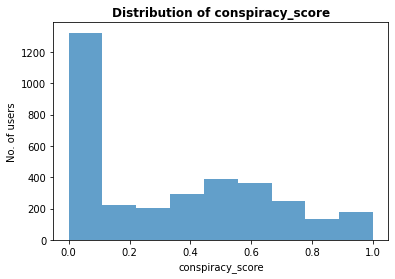

In [112]:
# distribution of scores
plt.hist(list(sum_of_urls_df_15['conspiracy_score']), bins=9, alpha=0.7)
plt.xlabel('conspiracy_score')
plt.ylabel('No. of users')
plt.title('Distribution of conspiracy_score', weight='bold')
#plt.savefig('plots/dist', bbox_inches='tight')
plt.show()

In [242]:
sum_of_urls_df = sum_of_urls_df_10

In [123]:
median = np.median(np.asarray(sum_of_urls_df_10['conspiracy_score'].dropna()))
median

0.23

In [244]:
t = 0.5
conditions = (sum_of_urls_df['conspiracy_score']<t)
sum_of_urls_df['credibility_classification'] = np.where(conditions , 'credible', 'NON credible')
sum_of_urls_df.head()

,number_of_urls,HIGH,LOW,UNKW,SOCIAL,conspiracy_score,credibility_classification
user_screen_name,,,,,,,
diego101garcia,15,0,15,0,0,1.0,NON credible
PierTossani,36,0,36,0,0,1.0,NON credible
romfrares,90,0,54,0,36,1.0,NON credible
Dario70864607,18,0,11,3,4,1.0,NON credible
LucianoTiramani,19,0,15,4,0,1.0,NON credible


In [245]:
len(sum_of_urls_df)

4524

In [246]:
non_cred = sum_of_urls_df[sum_of_urls_df['credibility_classification']== 'NON credible']

In [247]:
cred = sum_of_urls_df[sum_of_urls_df['credibility_classification']== 'credible']

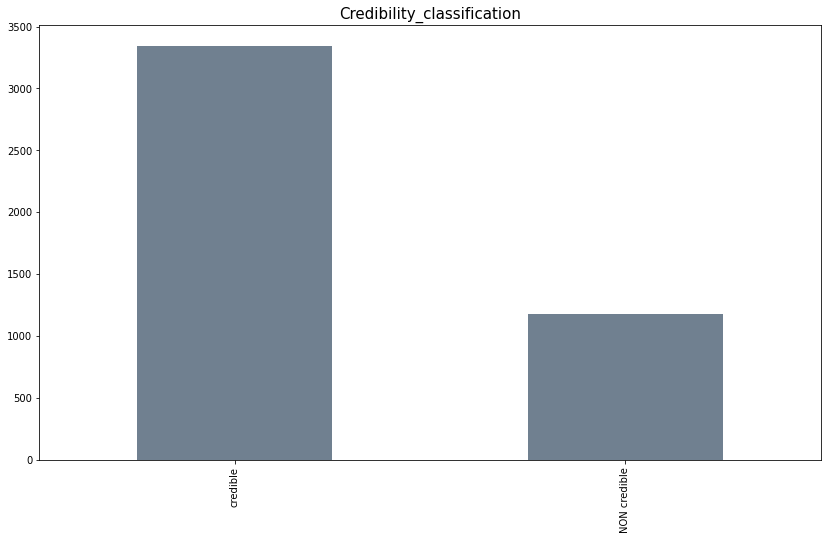

In [262]:
fig = plt.figure(figsize=(14, 8))
ax = sum_of_urls_df['credibility_classification'].value_counts(ascending=False)[:30].plot(kind='bar', color='slategrey', fig=(14,14)) #slategrey
ax.set_title('Credibility_classification', fontsize=15)
# ax.invert_yaxis()
plt.show()

In [261]:
sum_of_urls_df

,number_of_urls,HIGH,LOW,UNKW,SOCIAL,conspiracy_score,credibility_classification
user_screen_name,,,,,,,
diego101garcia,15,0,15,0,0,1.0,NON credible
PierTossani,36,0,36,0,0,1.0,NON credible
romfrares,90,0,54,0,36,1.0,NON credible
Dario70864607,18,0,11,3,4,1.0,NON credible
LucianoTiramani,19,0,15,4,0,1.0,NON credible
...,...,...,...,...,...,...,...
AvvDox,22,10,0,3,9,0.0,credible
marco__lecce,22,13,0,5,4,0.0,credible
em_eraldsea,15,10,0,1,4,0.0,credible


In [249]:
sum_of_urls_df['credibility_classification'].unique()

array(['NON credible', 'credible'], dtype=object)

In [264]:
sum_of_urls_df['user'] = sum_of_urls_df.index

In [265]:
sum_of_urls_df.to_csv(destination_path+"result_credibility.csv", index=False)

# USER ERROR

In [253]:
path_error = '/content/gdrive/My Drive/SUPSI/CSN_Project/'

In [254]:
user_error_df = pd.read_csv(path_error+'user_error_df.csv', lineterminator='\n')

In [255]:
user_error_df

,id,id_str,name,screen_name,code
0,560086917,560086917,Pietro Ragno,ThePRagno88,NaN
1,1140596424,1140596424,Gabry Albertini,ALBERTINIGabry,NaN
2,470349216,470349216,vito vitalozzo,vitalozzo2012,NaN
3,1006547627549319169,1006547627549319169,Nicolò Montarini,nicolomontarini,NaN
4,1304095580868636679,1304095580868636679,Hemal khan,Hemalkh90149688,NaN
...,...,...,...,...,...
286811,960163091676774401,960163091676774401,Yo＄hi,4416tksw,NaN
286812,533587191,533587191,Hair Straightening,RadianceSALON_,NaN
286813,1128241290,1128241290,Giovanni Bonomo,gbonomo1,NaN
286814,1018828109053943810,1018828109053943810,vincibellomo,vincibellomo,NaN


In [ ]:
sum_of_urls_df

,number_of_urls,HIGH,LOW,UNKW,SOCIAL,conspiracy_score,credibility_classification
user_screen_name,,,,,,,
lucianotiramani,12,0,10,2,0,1.0,NON credible
salernonotizie,758,0,757,1,0,1.0,NON credible
fabrizi58277161,56,0,10,12,34,1.0,NON credible
paulus00767325,17,0,17,0,0,1.0,NON credible
avg,46,0,46,0,0,1.0,NON credible
...,...,...,...,...,...,...,...
franzrusso,44,14,0,28,2,0.0,credible
cassio39592131,44,26,0,13,5,0.0,credible
bettasanlazzaro,44,18,0,11,15,0.0,credible


In [257]:
sum_of_urls_df

,number_of_urls,HIGH,LOW,UNKW,SOCIAL,conspiracy_score,credibility_classification
user_screen_name,,,,,,,
diego101garcia,15,0,15,0,0,1.0,NON credible
PierTossani,36,0,36,0,0,1.0,NON credible
romfrares,90,0,54,0,36,1.0,NON credible
Dario70864607,18,0,11,3,4,1.0,NON credible
LucianoTiramani,19,0,15,4,0,1.0,NON credible
...,...,...,...,...,...,...,...
AvvDox,22,10,0,3,9,0.0,credible
marco__lecce,22,13,0,5,4,0.0,credible
em_eraldsea,15,10,0,1,4,0.0,credible


In [ ]:
users = users.rename(columns={"screen_name": "user_screen_name"})

In [ ]:
sum_of_urls_df_compl = sum_of_urls_df.merge(users, how='left',on='user_screen_name')

In [ ]:
sum_of_urls_df_compl

,user_screen_name,number_of_urls,HIGH,LOW,UNKW,SOCIAL,conspiracy_score,credibility_classification,id,id_str,name,location,description,url,protected,followers_count,friends_count,listed_count,created_at,favourites_count,geo_enabled,verified,statuses_count,contributors_enabled,default_profile,default_profile_image
0,lucianotiramani,12,0,10,2,0,1.0,NON credible,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,salernonotizie,758,0,757,1,0,1.0,NON credible,294773912.0,294773912.0,Salernonotizie.it,Salerno,Salernonotizie è il sito di informazione di Sa...,https://t.co/t3qlwfyXQC,False,9511.0,221.0,187.0,Sat May 07 19:00:30 +0000 2011,30.0,True,False,172867.0,False,False,False
2,salernonotizie,758,0,757,1,0,1.0,NON credible,294773912.0,294773912.0,Salernonotizie.it,Salerno,Salernonotizie è il sito di informazione di Sa...,https://t.co/t3qlwfyXQC,False,9511.0,221.0,187.0,Sat May 07 19:00:30 +0000 2011,30.0,True,False,172869.0,False,False,False
3,salernonotizie,758,0,757,1,0,1.0,NON credible,294773912.0,294773912.0,Salernonotizie.it,Salerno,Salernonotizie è il sito di informazione di Sa...,https://t.co/t3qlwfyXQC,False,9511.0,221.0,187.0,Sat May 07 19:00:30 +0000 2011,30.0,True,False,172869.0,False,False,False
4,salernonotizie,758,0,757,1,0,1.0,NON credible,294773912.0,294773912.0,Salernonotizie.it,Salerno,Salernonotizie è il sito di informazione di Sa...,https://t.co/t3qlwfyXQC,False,9511.0,221.0,187.0,Sat May 07 19:00:30 +0000 2011,30.0,True,False,172869.0,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22233,tixxxtweety,44,14,0,2,28,0.0,credible,46922585.0,46922585.0,Titti Troccoli,"Milano, Italy, Earth",“I am the master of my fate: I am the captain ...,https://t.co/SfjUL73aFf,False,2052.0,4999.0,72.0,Sat Jun 13 17:11:28 +0000 2009,71378.0,True,False,51915.0,False,False,False
22234,tixxxtweety,44,14,0,2,28,0.0,credible,46922585.0,46922585.0,Titti Troccoli,"Milano, Italy, Earth",“I am the master of my fate: I am the captain ...,https://t.co/SfjUL73aFf,False,2052.0,4999.0,72.0,Sat Jun 13 17:11:28 +0000 2009,71379.0,True,False,51917.0,False,False,False
22235,tixxxtweety,44,14,0,2,28,0.0,credible,46922585.0,46922585.0,Titti Troccoli,"Milano, Italy, Earth",“I am the master of my fate: I am the captain ...,https://t.co/SfjUL73aFf,False,2052.0,4999.0,72.0,Sat Jun 13 17:11:28 +0000 2009,71380.0,True,False,51918.0,False,False,False
22236,tixxxtweety,44,14,0,2,28,0.0,credible,46922585.0,46922585.0,Titti Troccoli,"Milano, Italy, Earth",“I am the master of my fate: I am the captain ...,https://t.co/SfjUL73aFf,False,2052.0,4999.0,72.0,Sat Jun 13 17:11:28 +0000 2009,71380.0,True,False,51918.0,False,False,False


In [ ]:
sum_of_urls_df_compl

,user_screen_name,number_of_urls,HIGH,LOW,UNKW,SOCIAL,conspiracy_score,credibility_classification,id,id_str,name,location,description,url,protected,followers_count,friends_count,listed_count,created_at,favourites_count,geo_enabled,verified,statuses_count,contributors_enabled,default_profile,default_profile_image
0,lucianotiramani,12,0,10,2,0,1.0,NON credible,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,salernonotizie,758,0,757,1,0,1.0,NON credible,294773912.0,294773912.0,Salernonotizie.it,Salerno,Salernonotizie è il sito di informazione di Sa...,https://t.co/t3qlwfyXQC,False,9511.0,221.0,187.0,Sat May 07 19:00:30 +0000 2011,30.0,True,False,172867.0,False,False,False
2,salernonotizie,758,0,757,1,0,1.0,NON credible,294773912.0,294773912.0,Salernonotizie.it,Salerno,Salernonotizie è il sito di informazione di Sa...,https://t.co/t3qlwfyXQC,False,9511.0,221.0,187.0,Sat May 07 19:00:30 +0000 2011,30.0,True,False,172869.0,False,False,False
3,salernonotizie,758,0,757,1,0,1.0,NON credible,294773912.0,294773912.0,Salernonotizie.it,Salerno,Salernonotizie è il sito di informazione di Sa...,https://t.co/t3qlwfyXQC,False,9511.0,221.0,187.0,Sat May 07 19:00:30 +0000 2011,30.0,True,False,172869.0,False,False,False
4,salernonotizie,758,0,757,1,0,1.0,NON credible,294773912.0,294773912.0,Salernonotizie.it,Salerno,Salernonotizie è il sito di informazione di Sa...,https://t.co/t3qlwfyXQC,False,9511.0,221.0,187.0,Sat May 07 19:00:30 +0000 2011,30.0,True,False,172869.0,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22233,tixxxtweety,44,14,0,2,28,0.0,credible,46922585.0,46922585.0,Titti Troccoli,"Milano, Italy, Earth",“I am the master of my fate: I am the captain ...,https://t.co/SfjUL73aFf,False,2052.0,4999.0,72.0,Sat Jun 13 17:11:28 +0000 2009,71378.0,True,False,51915.0,False,False,False
22234,tixxxtweety,44,14,0,2,28,0.0,credible,46922585.0,46922585.0,Titti Troccoli,"Milano, Italy, Earth",“I am the master of my fate: I am the captain ...,https://t.co/SfjUL73aFf,False,2052.0,4999.0,72.0,Sat Jun 13 17:11:28 +0000 2009,71379.0,True,False,51917.0,False,False,False
22235,tixxxtweety,44,14,0,2,28,0.0,credible,46922585.0,46922585.0,Titti Troccoli,"Milano, Italy, Earth",“I am the master of my fate: I am the captain ...,https://t.co/SfjUL73aFf,False,2052.0,4999.0,72.0,Sat Jun 13 17:11:28 +0000 2009,71380.0,True,False,51918.0,False,False,False
22236,tixxxtweety,44,14,0,2,28,0.0,credible,46922585.0,46922585.0,Titti Troccoli,"Milano, Italy, Earth",“I am the master of my fate: I am the captain ...,https://t.co/SfjUL73aFf,False,2052.0,4999.0,72.0,Sat Jun 13 17:11:28 +0000 2009,71380.0,True,False,51918.0,False,False,False


In [ ]:
sum_of_urls_df_compl.to_csv(path_url+"sum_of_urls_df_compl.csv", index=False)

In [ ]:
sum_of_urls_df_compl_info = sum_of_urls_df_compl.merge(user_error_df, how='left',on='id')

In [ ]:
selected_columns_users = sum_of_urls_df_compl_info[["id",	"screen_name", "code", "number_of_urls",	"HIGH",	"LOW",	"UNKW",	"SOCIAL",	"conspiracy_score",	"credibility_classification"]]

info_on_users = selected_columns_users.copy()

In [ ]:
info_on_users

,id,screen_name,code,number_of_urls,HIGH,LOW,UNKW,SOCIAL,conspiracy_score,credibility_classification
0,NaN,NaN,NaN,12,0,10,2,0,1.0,NON credible
1,294773912.0,salernonotizie,NaN,758,0,757,1,0,1.0,NON credible
2,294773912.0,salernonotizie,NaN,758,0,757,1,0,1.0,NON credible
3,294773912.0,salernonotizie,NaN,758,0,757,1,0,1.0,NON credible
4,294773912.0,salernonotizie,NaN,758,0,757,1,0,1.0,NON credible
...,...,...,...,...,...,...,...,...,...,...
22233,46922585.0,tixxxtweety,NaN,44,14,0,2,28,0.0,credible
22234,46922585.0,tixxxtweety,NaN,44,14,0,2,28,0.0,credible
22235,46922585.0,tixxxtweety,NaN,44,14,0,2,28,0.0,credible
22236,46922585.0,tixxxtweety,NaN,44,14,0,2,28,0.0,credible


In [ ]:
len(info_on_users[info_on_users['code'].notna()])

59

In [ ]:
info_on_users[info_on_users['code'].notna()].drop_duplicates()

,id,screen_name,code,number_of_urls,HIGH,LOW,UNKW,SOCIAL,conspiracy_score,credibility_classification
6474,3.159375e+09,venetolink,63.0,186,20,15,26,125,0.43,credible
10706,1.032863e+18,giusepp69152402,63.0,21,8,2,6,5,0.20,credible
11769,4.125886e+09,geremia767,63.0,68,15,2,18,33,0.12,credible
13797,2.304070e+08,hurried57,50.0,32,19,1,12,0,0.05,credible
17186,2.333459e+08,bicidiario,50.0,81,13,0,25,43,0.00,credible
